# Exercise 2

Required python packages

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import os
import logging
from logging import debug, info, warning, error
from tqdm import tqdm
from numba import njit, jit, prange

In [9]:
np.random.seed(42)
SAVE_PATH = 'temp_media/ex2'
LOG_PATH = 'log'
ANIM_BACKEND = 'ffmpeg'
os.makedirs(SAVE_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)
logging.basicConfig(level='DEBUG', filename=f'{LOG_PATH}/ex2.log', filemode='w', format='%(msecs)d (%(name)s) %(levelname)s: %(message)s', datefmt='%H:%M:%S')
logging.getLogger('numba').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

Check for CUDA availability for GPU compute

In [10]:
from numba import cuda

CUDA = False

try:
    CUDA = cuda.detect()
    info('CUDA is available.')
except ImportError:
    info('CUDA is not available. Uses CPU for computations instead.')

SOR solver for solving Laplace equation and getting concentration gradients at final iteration

## TODO: How to manage y=0 case i.e. j=0. Since it's (presumably) not a sink, we can't ignore it like before

In [11]:
@jit(nopython=True, parallel=True)
def sor_parallel(c: np.ndarray, omega: float, obj: np.ndarray, epsilon=1e-6, max_iterations=10_000):
    '''Solves the Laplace equation using the red-black parallel Successive Over-Relaxation (SOR) method introduced in Set 1'''
    converged = False
    Nx = c.shape[0]  # Assume 2D square lattice

    for n in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check

        # Red points
        for i in prange(0, Nx):
            for j in range(0, Nx-1):  # exclude y=Nx source
                if (i + j) % 2 == 0:
                    if obj[i, j] == 0:
                        # for periodic boundaries, note use of (i+1)% Nx, i-1 pythonically wraps to index -1
                        # for j=0, j-1 is excluded
                        # max to ensure non-negative concentrations
                        if j == 0: # TODO: is this okay to do? We are messing with concentrations here to manage y=0
                            c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                        else:
                            c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1]), 0)
                    else:
                        c[i, j] = 0.0

        # Black points | same comments as above
        for i in prange(0, Nx):
            for j in range(0, Nx-1):
                if (i + j) % 2 == 1:
                    if obj[i, j] == 0:
                        if j == 0:
                            c[i, j] = max((1-omega)*c[i, j] + omega/3 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] + c[i, j+1]), 0)
                        else:
                            c[i, j] = max((1-omega)*c[i, j] + omega*0.25 * \
                                (c[(i+1) % Nx, j] + c[i-1, j] +
                                 c[i, j+1] + c[i, j-1]), 0)
                    else:
                        c[i, j] = 0.0

        # Check for convergence
        if np.max(np.abs(c - c_old)) < epsilon:
            converged = True
            # info(f'Converged after {n} iterations using omega={omega}.')
            break

    return c, n, converged


# doesn't work with numba
# def has_converged(c_new, c_old, epsilon) -> bool:
#     '''Check if the SOR solver has converged to a stead state solution.'''
#     return np.max(np.abs(c_new - c_old)) < epsilon


def plot_laplace_grid(c, title, filename):
    plt.figure(figsize=(5, 4), layout='tight')
    plt.imshow(np.rot90(c, 3), origin='lower')
    plt.colorbar(label='Concentration')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig(f'{SAVE_PATH}/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

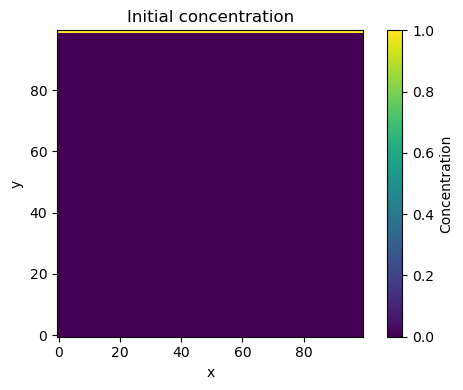

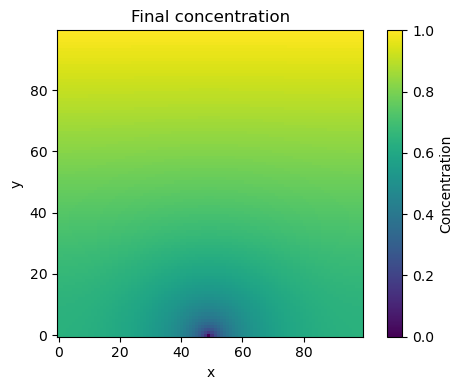

In [12]:
Nx = 100
omega = 1.7

c = np.zeros((Nx, Nx))
c[:, -1] = 1.0
c[Nx//2, 0] = 0.0
c_init = c.copy()

obj = np.zeros((Nx, Nx), dtype=int)  # growing object
obj[Nx//2, 0] = 1

c, iter, converged = sor_parallel(c, omega, obj)
plot_laplace_grid(c_init, 'Initial concentration', 'initial_concentration')
plot_laplace_grid(c, 'Final concentration', 'final_concentration')

In [13]:
def simulate_dla_growth_model(Nt, Nx=100, max_sor_iter=1_000, omega=1.7, epsilon=1e-6, seed_pos='lower center', init_optimize=True):
    '''Simulates the Diffusion Limited Aggregation (DLA) growth model'''
    # Growth object
    seed_pos_idx = get_seed_position(Nx, seed_pos)

    obj = np.zeros((Nx, Nx), dtype=int)
    obj[*seed_pos_idx] = 1
    debug(f'Number of non-zero object elements after initialization: {np.count_nonzero(obj)}.')

    c = setup_concentration_matrix(Nx, seed_pos_idx, init_optimize)

    for iter in tqdm(range(Nt)):
        c, sor_iter, converged = sor_parallel(
            c, omega, obj, epsilon, max_sor_iter)
        
        if not converged:
            raise ValueError(f'SOR convergence for DLA time step {iter} not reached after {sor_iter} iterations. ' + 
                             'Increase `max_iterations` or decrease `epsilon`.')
        else:
            debug(f'SOR converged after {sor_iter} iterations.')

        growth_candidates = get_candidates(obj)
        candidate_probabilities = get_candidate_probabilities(
            c, growth_candidates)
        
        candidate_indices = np.linspace(0, len(growth_candidates)-1, len(growth_candidates), dtype=int)
        
        chosen_idx = np.random.choice(candidate_indices, p=candidate_probabilities)

        selected_candidate_idx = growth_candidates[chosen_idx]
        debug(f'Selected candidate: {tuple(selected_candidate_idx)} with p={candidate_probabilities[chosen_idx]:.3f}.')

        obj[*selected_candidate_idx] = 1
        debug(f'{np.count_nonzero(obj)} non-zero object elements after iteration {iter}.')

    return c, obj, iter
    

def setup_concentration_matrix(Nx, seed_pos_idx, init_optimize):
    c = np.zeros((Nx, Nx))
    c[:, -1] = 1  # top is source

    # Optimization: initial guess for stable concentration profile using analytical solution
    if init_optimize:
        y = np.linspace(0, 1, Nx)
        for i, y_i in enumerate(y):
            c[:, i] = y_i

    c[*seed_pos_idx] = 0

    return c


def get_seed_position(Nx, seed_pos: str):
    arg_list = seed_pos.lower().split(' ')

    if len(arg_list) == 0 or len(arg_list) == 1 and arg_list[0] != 'center':
        raise ValueError('Invalid seed position. Please provide positioning for both x and y coordinates or use "center".')
    elif len(arg_list) == 1 and arg_list[0] == 'center':
        return (Nx//2, Nx//2)

    seed_pos_h_dict = {
        'left': 0,
        'center': Nx//2,
        'right': Nx-1
    }

    x = seed_pos_h_dict.get(arg_list[-1], -1)
        
    seed_pos_v_dict = {
        'lower': 0,
        'center': Nx//2,
        'upper': Nx-1
    }

    y = seed_pos_v_dict.get(arg_list[0], -1)

    if x == -1 or y == -1:
        raise ValueError('Invalid seed position. Please provide valid positioning for both x and y coordinates or use "center".')

    return (x, y)



def get_candidates(obj):
    '''Utility functionality to get the van Neumann (Manhattan distance = 1) neighbors (growth candidates) of the object.
    Returns a numpy array of the indices of the growth candidates'''
    obj_indices = np.argwhere(obj == 1)
    Nx = obj.shape[0] # assume square
    growth_candidates = set()

    # consider all von Neumann neighbors of the object that aren't the object as candidates
    for i, j in obj_indices:
        if obj[i-1, j] == 0:
            growth_candidates.add((i-1, j))
        if obj[(i+1) % Nx, j] == 0:
            growth_candidates.add(((i+1) % Nx, j))
        if j > 0 and obj[i, j-1] == 0:
            growth_candidates.add((i, j-1))
        if j < Nx-1 and obj[i, j+1] == 0:
            growth_candidates.add((i, j+1))

    if len(growth_candidates) == 0:
        warning(f'No more growth candidates found.')
    else:
        debug(f'Found {len(growth_candidates)} growth candidates.')

    return np.array(list(growth_candidates))


def get_candidate_probabilities(c, growth_candidates):
    '''Utility functionality to get the probability of growth for each candidate based on its concentration.'''
    candidate_probabilities = np.zeros(len(growth_candidates))

    for i, (x, y) in enumerate(growth_candidates):
        candidate_probabilities[i] = c[x, y]

    sum_probabilities = np.sum(candidate_probabilities)

    if np.any(candidate_probabilities < 0):
        debug('Negative growth probabilities found. Should be impossible as `soc_parallel` should be preventing this.')
        debug(f'Growth candidate matrix:\n{growth_candidates}')
        debug(f'Candidate probabilities:\n{candidate_probabilities}')
        raise ValueError('Negative growth probabilities found.')

    if sum_probabilities <= 0:
        raise ValueError(
            'Sum of probabilities is (less than or equal) zero but neighbors were found. Either all neighbors have concentration exactly 0 (unlikely) or there is another issue. Please check the concentration matrix.')
    
    candidate_probabilities /= sum_probabilities

    return candidate_probabilities


def select_best_omega_for_sor(omega_values, epsilon, c_init, seed_pos='lower center', max_iterations=10_000):
    '''Finds the best relaxation parameter omega for SOR'''

    best_omega = 0
    least_iter = max_iterations

    # Growth object
    seed_pos_idx = get_seed_position(Nx, seed_pos)
    obj = np.zeros((Nx, Nx), dtype=int)
    obj[*seed_pos_idx] = 1
    debug(f'Number of non-zero object elements after initialization: {np.count_nonzero(obj)}.')

    for omega in tqdm(omega_values):
        c = c_init.copy()
        c, n_iter, converged = sor_parallel(c, omega, obj, epsilon, max_iterations)
        if converged and n_iter < least_iter:
            least_iter = n_iter
            best_omega = omega
            c_converged = c.copy()
        # else:
        #     debug(f'Convergence not reached for omega={omega}.')
    if best_omega == 0:
        raise ValueError(f'Unable to converge using provided omega values {omega_values} within {max_iterations} steps. ' + 
                         'Please provide larger omega range and/or maximum iteration count to reach convergence.')
    return c_converged, best_omega, least_iter

## TODO: Fix plotting of object on top of grid
## TODO: Fix negative probabilities in np.random.choice showing up roughly every 20 runs. Something at the borders? With 1 or 0 neighbors?

100%|██████████| 1500/1500 [00:20<00:00, 72.93it/s] 


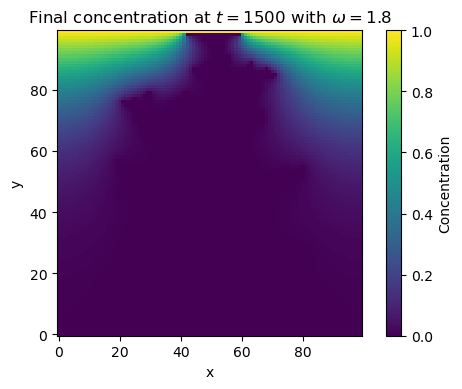

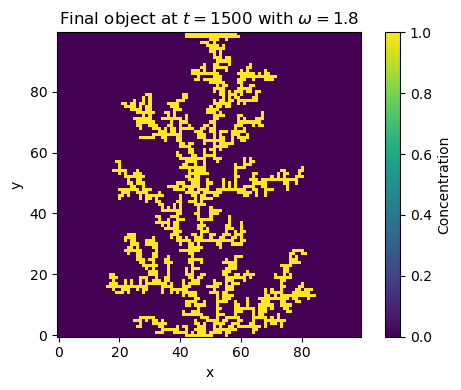

In [14]:
# _, omega, _ = select_best_omega_for_sor(np.linspace(1.0, 1.9, 20), 1e-6, c_init)
omega = 1.8
Nt = 1500
Nx = 100
max_sor_iter = 10_000
c, obj, iter = simulate_dla_growth_model(Nt=Nt, Nx=Nx, max_sor_iter=max_sor_iter, omega=omega, init_optimize=True)
plot_laplace_grid(c, f'Final concentration at $t={Nt}$ with $\\omega = {omega}$', 'final_concentration_dla')
plot_laplace_grid(obj, f'Final object at $t={Nt}$ with $\\omega = {omega}$', 'final_object_dla')